In [1]:
# locations = np.array([(y, x) for x in range(body_img.shape[0]) for y in range(body_img.shape[1]) if body_img[x][y] == 0])
# np.save('raw/myshape',locations)

In [2]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
import imageio
from myfunc import clip_background,cv2plot,set_borders_zero,resize_by_ratio,morph_line
%matplotlib inline

In [3]:
def extract_body(body_shape,treashhold=0.5,border_width = 3,blurloop=5):
    body_shape = np.clip(body_shape, 0, 1)
    body_shape = np.ceil(body_shape-treashhold)
    body_shape = set_borders_zero(body_shape,border_width)
    
    kernel = np.ones((30, 30), np.uint8)
    d_im = cv2.dilate(body_shape, kernel, iterations=1)   #b2 已经二值化
    d_im = morphology.skeletonize(d_im).astype(np.float32)
    mymask = np.zeros((d_im.shape[0]+2,d_im.shape[1]+2))
    mymask = np.mat(mymask,np.uint8)
    d_im = cv2.floodFill(d_im,mymask,(0,0),1)[1] #图像左上角开始，大背景填充1
    for i in range(blurloop):
        d_im = cv2.medianBlur(d_im, 5)
        d_im = cv2.GaussianBlur(d_im,(5,5),0)
    d_im = np.ceil(d_im-0.5)    
    return d_im

In [4]:
def load_img(img_path,resize_shape,treashhold = 0.5,denoise1 = 5,denoise2 = 3):
    raw = cv2.imread(img_path)
    raw = np.array(raw, dtype=np.float32) / 255.0
    (b, g, r) = cv2.split(raw)
    fish_gray = 1 * g - b - r
    fish_img = np.clip(fish_gray, 0, 1)
    fish_img = np.ceil(fish_img-treashhold)
    body_img = extract_body(b)
    body_img,fish_img = clip_background(body_img,fish_img,denoise1 = denoise1,denoise2 = denoise2)
        
    fish_img = cv2.resize(fish_img, (resize_shape[1],resize_shape[0]), interpolation = cv2.INTER_NEAREST)
    body_img = cv2.resize(body_img, (resize_shape[1],resize_shape[0]), interpolation = cv2.INTER_NEAREST)
    
#     ####### notsure if it can work:????????????????????????????
#     kernel = np.ones((2, 2), np.uint8)
#     fish_img = cv2.dilate(fish_img, kernel, iterations=1)
#     fish_img = cv2.erode(fish_img, kernel, iterations=1)
#     body_img = cv2.dilate(body_img, kernel, iterations=1)
#     body_img = cv2.erode(body_img, kernel, iterations=1)
    
    return fish_img,body_img

In [5]:
def load_target_shape(tar_img_path,threshold = 0.4,denoise1 = 5,denoise2 = 3):
    tar = cv2.imread(tar_img_path,0)            
    tar = tar/255
    tar = cv2.threshold(tar,threshold,1,cv2.THRESH_BINARY)[1]
    tar,_ = clip_background(tar,[],denoise1 = denoise1,denoise2 = denoise2)
    return tar

In [6]:
def transformation(fish_img,body_img,tar_img):
           
#     # extract skeleton -- marked as 1   TODO: 把涡虫摆正拉直 写个def
#     body_skl = morphology.skeletonize(body_img*-1+1).astype(np.float32)
#     tar_skl = morphology.skeletonize(tar_img*-1+1).astype(np.float32)    
       
    new_body_img = np.ndarray(tar_img.shape)
    new_fish_img = np.ndarray(tar_img.shape)
    
    for i in range(len(tar_img)):
        ####### notsure if it can work:????????????????????????????
        try:
            morph,submorph = morph_line(body_img[i],fish_img[i],tar_img[i])
            new_body_img[i,:]=morph
            new_fish_img[i,:]=submorph
        except:
            print('empty row:{}'.format(i))
        
    return new_body_img,new_fish_img

### workflow

In [7]:
filelist = pd.read_csv('raw/meta.txt',header=None)
filelist = filelist.values.squeeze().tolist()

In [8]:
atlas_dict = {}

# load target space
locations = np.load('raw/myshape.npy')


# Image processing & atlas generation
for filename in filelist:
    genename = filename.split('.')[0]
    img_path = 'raw/{}'.format(filename)
    tar_img_path = 'raw/myshape.jpg'  #SMED30017714
    
    tar_img = load_target_shape(tar_img_path)
    fish_img,body_img = load_img(img_path,tar_img.shape,treashhold = 0.4)

    new_body_img,new_fish_img = transformation(fish_img,body_img,tar_img)
    chk = new_body_img+new_fish_img
    imageio.imsave('chk/{}.jpg'.format(filename),chk,format='jpg')
    
    # atlas generation
    atlas = [int(new_fish_img[loc[1]][loc[0]]) for loc in locations]
    np.save('chk/{}'.format(genename),atlas)
    atlas_dict[genename] = atlas
    
atlas_df = pd.DataFrame(atlas_dict)    
atlas_df.to_csv('raw/atlas.txt', sep='\t', index=False)    

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

### generate target space and atlas
Target space -- (y,x) collection of the body shape  ----- save as .npy   
Atlas -- for points in target space, show gene's expression level, 1 col for 1 gene, header as gene_name ---- save as txt/csv??

In [9]:
# Target space --- currently saved as 'raw/myshape.npy'
# locations = np.array([(y, x) for x in range(body_img.shape[0]) for y in range(body_img.shape[1]) if body_img[x][y] == 0])

# If pos in Target space shows expression (1), label as 1
# atlas = [int(new_fish_img[loc[1]][loc[0]]) for loc in locations]


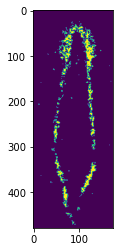

In [10]:
plt.imshow(new_fish_img)